In [98]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

In [99]:
file_path = r"~/poincare/cancer_regression/data/cancer_reg.csv"
cancer_df = pd.read_csv(file_path)
cancer_df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [100]:
train_set, test_set = train_test_split(cancer_df, test_size = 0.2) # now have a training set and a testing set! Yay!

In [104]:
cancer_df = train_set.drop("TARGET_deathRate", axis=1).copy()
cancer_labels = train_set["TARGET_deathRate"].copy()

2992    152.6
1661    186.3
2081    185.5
2180    197.8
1636    179.5
Name: TARGET_deathRate, dtype: float64

In [105]:
corr_matrix = cancer_df.corr(numeric_only=True)

In [106]:
attributes = ["TARGET_deathRate", "medIncome", "povertyPercent", "MedianAge", "PctPublicCoverage", "PctPrivateCoverageAlone", "PctPrivateCoverage", "PctEmpPrivCoverage"]

In [12]:
# There's a lot here.
# We can predict a lot of these features using a lot of these features.
# It's clear here that the TARGET_deathRate is positively correlated with both povertyPercent and PctPublicCoverage
# Moreover, TARGET_deathRate is negatively correlated with medIncome

<Axes: xlabel='povertyPercent', ylabel='TARGET_deathRate'>

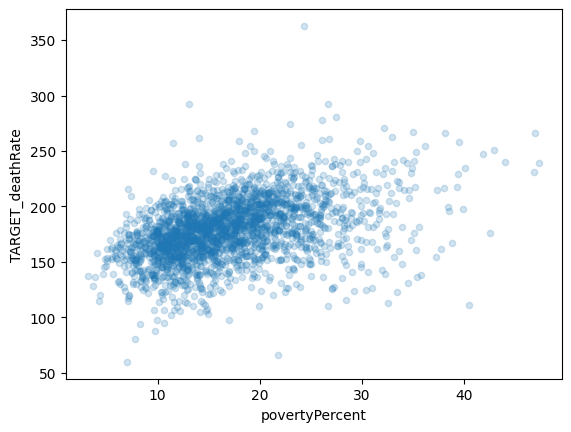

In [83]:
cancer_df.plot(kind="scatter", x="povertyPercent", y="TARGET_deathRate", alpha=0.2)

<Axes: xlabel='PctPublicCoverage', ylabel='TARGET_deathRate'>

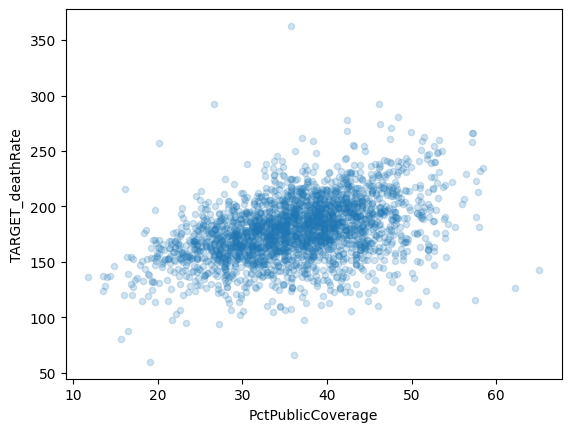

In [84]:
cancer_df.plot(kind="scatter", x="PctPublicCoverage", y="TARGET_deathRate", alpha=0.2)

<Axes: xlabel='medIncome', ylabel='TARGET_deathRate'>

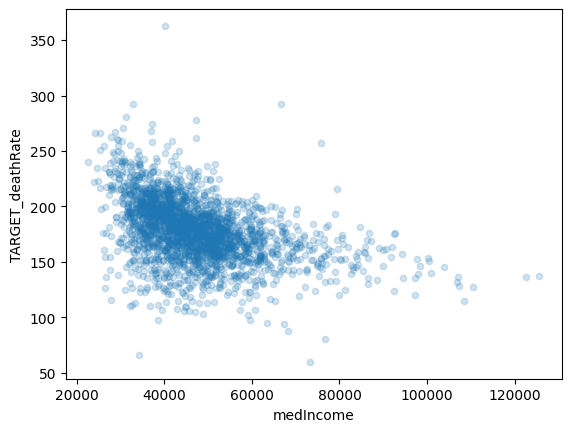

In [85]:
cancer_df.plot(kind="scatter", x="medIncome", y="TARGET_deathRate", alpha=0.2)

In [16]:
# Upon first glance it doesn't seem like there are any worthwhile new data points we could make from existing ones.
# We could possibly scale down median age, but I doubt that age generally plays a significant role in cancer mortality rate.

In [17]:
# Now we do data cleaning
# I'd like to operate only on povertyPercent, PctPublicCoverage, medIncome to predict TARGET_deathRate

In [27]:
pd.options.future.infer_string = True

In [108]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

# To use SimpleImputer, we must eliminate the non-numerical values.
# Check column types

categ_attribs = []
for i in range (len(cancer_df.select_dtypes(include=object).columns)):
    categ_attribs.append(cancer_df.select_dtypes(include=object).columns[i])

categ_attribs
    
cancer_numerical = cancer_df.drop(categ_attribs, axis=1)

cancer_df["Geography"]

cancer_numerical.head()

# Axis 1 is columns, axis 0 is rows

cancer_numerical.isnull().sum() #PctPrivateCoverageAlone, PctEmployed16_Over, PctSomeCol18_24

# Transform missing values into np.nan

cancer_numerical.dropna(inplace=True, axis=0)

imputer.fit_transform(cancer_numerical)

cancer_numerical.dtypes


avgAnnCount                float64
avgDeathsPerYear             int64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite                   float64
PctBlack                   float64
PctAsian                   float64
PctOtherRace        

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler())])
full_pipeline = Pipeline([('num', numeric_pipeline)])
cancer_prepped = full_pipeline.fit_transform(cancer_numerical)

In [116]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
cancer_labels_truncated = cancer_labels[:482]
lin_reg.fit(cancer_prepped, cancer_labels_truncated)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [129]:
some_data = cancer_numerical.iloc[:5]
some_labels = cancer_labels_truncated.iloc[:5]
some_data_prepared = full_pipeline.fit_transform(some_data)
print(f'Predictions: {lin_reg.predict(some_data_prepared)}')

Predictions: [ 410.66920886  167.82392076  100.51579215 -107.42258008  315.4344052 ]


In [132]:
print(f'Labels: {list(some_labels)}')

Labels: [152.6, 186.3, 185.5, 197.8, 179.5]


In [133]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(cancer_prepared)
lin_mse = mean_squared_error(cancer_labels_truncated)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

NameError: name 'cancer_prepared' is not defined